In [1]:
import numpy as np 
import pandas as pd
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from scipy import special
from tqdm import tqdm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif



warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)

In [2]:
X_train = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/X_train_corr.csv')
y_train = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/y_train_large.csv').squeeze()
X_test = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/X_test_corr.csv')
y_test = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/y_test_large.csv').squeeze()

In [3]:
X_train.head()

,age,bmi,elective_surgery,gender,height,icu_id,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,icu_id_counts,age_counts,nan_counts,sq_age,sq_bmi,bmi_age,weight_age,comorbidity_score,diabete_risk,gcs_sum,apache_2_diagnosis_type,bmi_type,height_type,weight_type,age_type,gcs_sum_type,apache_3j_diagnosis_split1,apache_2_diagnosis_split1,profile,diff_bmi,bilirubin_d1_h1_max_eq,bilirubin_d1_h1_min_eq,bilirubin_h1_value_range,bilirubin_h1_zero_range,bilirubin_h1_mean,bilirubin_h1_std,bilirubin_h1_max_apache_3j_diagnosis_mean,bilirubin_h1_max_apache_3j_diagnosis_diff,bilirubin_h1_max_apache_3j_diagnosis_std,bilirubin_h1_max_apache_3j_diagnosis_norm_std,bilirubin_h1_max_apache_3j_diagnosis_rank,bilirubin_h1_max_apache_3j_diagnosis_count,bilirubin_h1_max_apache_3j_diagnosis_norm_rank,bilirubin_h1_max_apache_3j_diagnosis_skew,bilirubin_h1_min_apache_3j_diagnosis_mean,bilirubin_h1_min_apache_3j_diagnosis_diff,bilirubin_h1_min_apache_3j_diagnosis_std,bilirubin_h1_min_apache_3j_diagnosis_norm_std,bilirubin_h1_min_apache_3j_diagnosis_rank,bilirubin_h1_min_apache_3j_diagnosis_norm_rank,bilirubin_h1_min_apache_3j_diagnosis_skew,bilirubin_h1_max_profile_mean,bilirubin_h1_max_profile_diff,bilirubin_h1_max_profile_std,bilirubin_h1_max_profile_norm_std,bilirubin_h1_max_profile_rank,bilirubin_h1_max_profile_count,bilirubin_h1_max_profile_norm_ran

In [4]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def lightgbm_feature_importance_selection(X_train, y_train, X_test, k=None, importance_type='gain', cumulative_threshold=0.95, random_state=42):
    """
    Selects top features based on LightGBM feature importances.
    
    Parameters:
    - X_train (pd.DataFrame): Training feature set.
    - y_train (pd.Series): Training target variable.
    - X_test (pd.DataFrame): Testing feature set.
    - k (int, optional): Number of top features to select. If None, uses cumulative_threshold.
    - importance_type (str): Type of feature importance ('split' or 'gain').
    - cumulative_threshold (float): Cumulative importance threshold (0 < threshold <= 1).
    - random_state (int): Random state for reproducibility.
    
    Returns:
    - X_train_selected (pd.DataFrame): Training set with selected features.
    - X_test_selected (pd.DataFrame): Testing set with selected features.
    - selected_features (list): List of selected feature names.
    """
    # Initialize the LightGBM classifier
    model = lgb.LGBMClassifier(
        random_state=random_state,
        n_jobs=-1,
        force_col_wise=True
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Extract feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    
    # Sort features by importance
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    feature_importances_sorted.plot(kind='bar')
    plt.title(f'LightGBM Feature Importances ({importance_type})')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()
    
    # Calculate cumulative importance
    cumulative_importance = feature_importances_sorted.cumsum() / feature_importances_sorted.sum()
    
    # Plot cumulative importance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_importance)+1), cumulative_importance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Feature Importance')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.grid(True)
    plt.axhline(y=cumulative_threshold, color='r', linestyle='-')
    plt.text(0.5, cumulative_threshold + 0.01, f'{int(cumulative_threshold*100)}% Threshold', color='red', fontsize=12)
    plt.show()
    
    # Decide on number of features
    if k is not None:
        selected_features = feature_importances_sorted.head(k).index.tolist()
        print(f"Selected top {k} features based on LightGBM feature importances.")
    else:
        # Find the number of features to reach the cumulative threshold
        n_features = np.argmax(cumulative_importance >= cumulative_threshold) + 1
        selected_features = feature_importances_sorted.head(n_features).index.tolist()
        print(f"Selected top {n_features} features to reach {int(cumulative_threshold*100)}% cumulative importance.")
    
    # Reduce the datasets to the selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    return X_train_selected, X_test_selected, selected_features


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 850113
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 3698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296


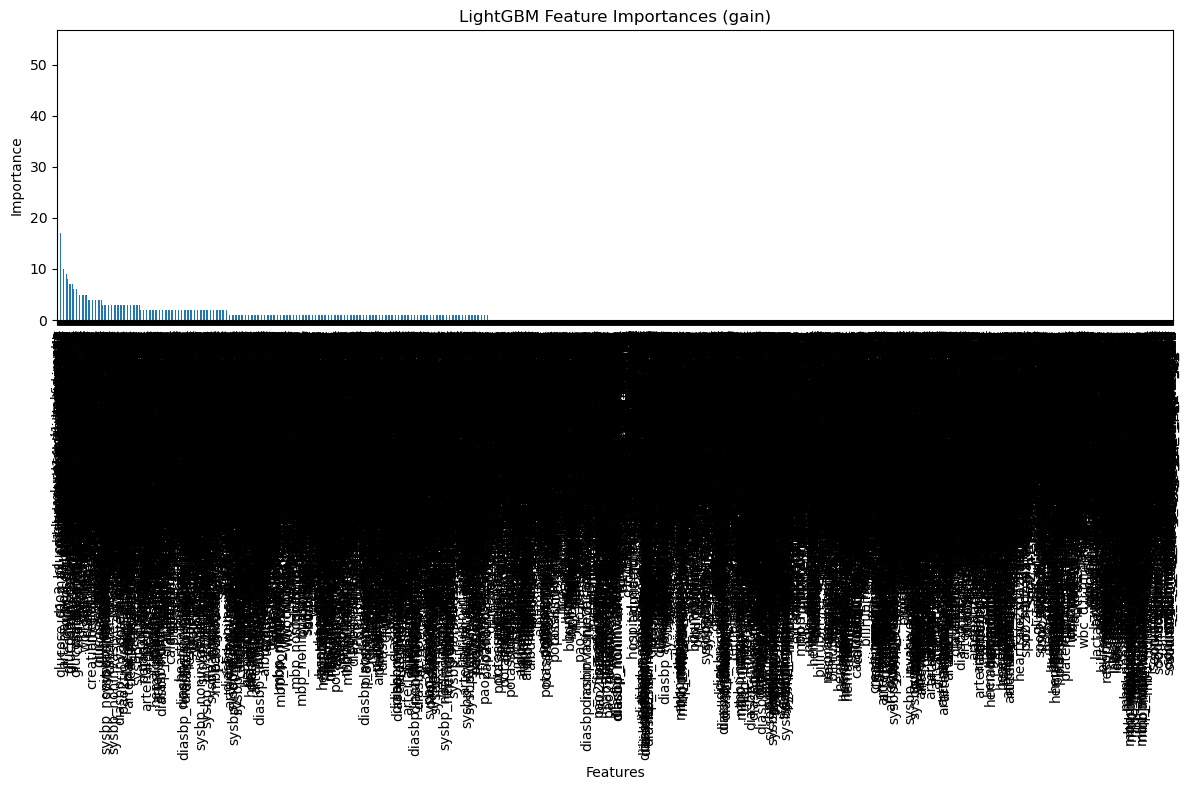

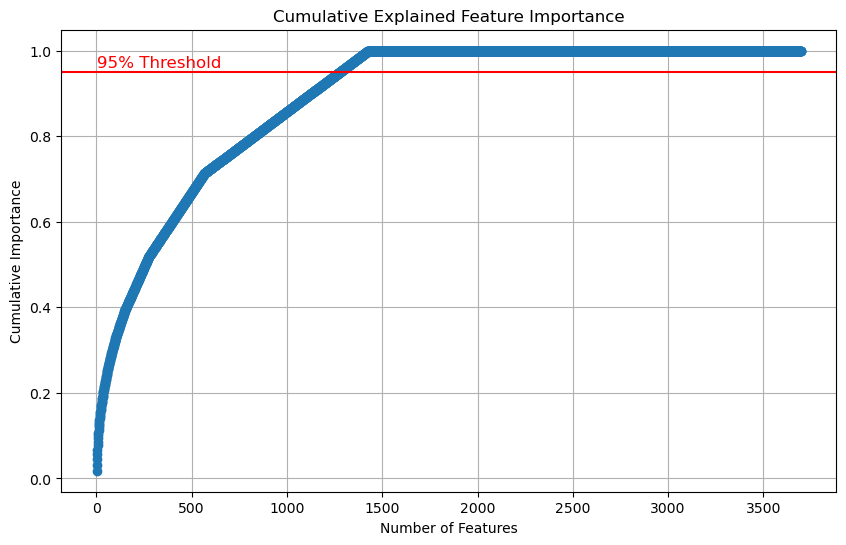

Selected top 1277 features to reach 95% cumulative importance.


In [5]:
X_train_lgbm_cum, X_test_lgbm_cum, selected_features_lgbm_cum = lightgbm_feature_importance_selection(
    X_train, y_train, X_test, k=None, importance_type='gain', cumulative_threshold=0.95, random_state=42
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.828838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850113
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 3698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23832
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> 

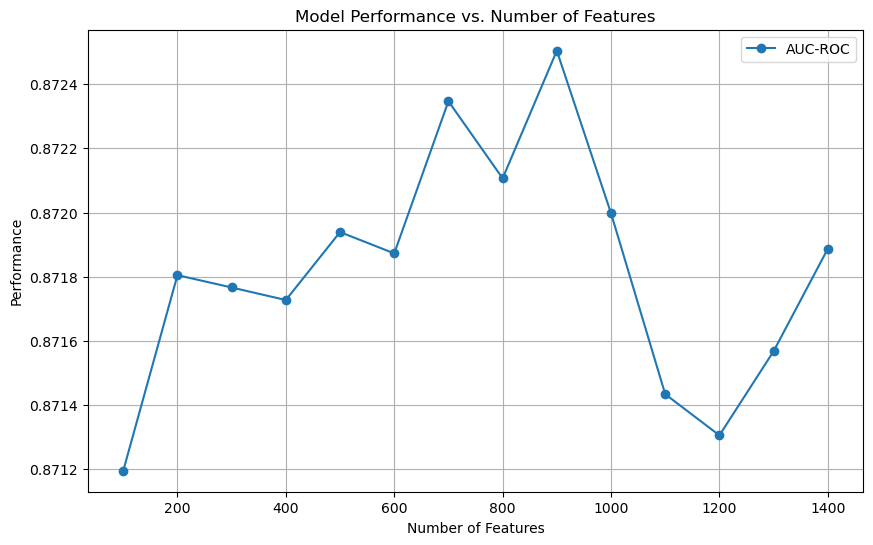

In [6]:
auc_scores = []
n_features_list = list(range(100, 1500, 100))  
rf = LGBMClassifier(random_state=69, n_jobs=-1)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 

for n in n_features_list:
    # Select the top `n` features
    top_n_indices = indices[:n]
    
    # Create datasets with the top `n` features
    X_train_top_n = X_train.iloc[:, top_n_indices]
    X_test_top_n = X_test.iloc[:, top_n_indices]
    
    # Retrain the model using only the top `n` features
    rf.fit(X_train_top_n, y_train)
    
    # Make predictions on the test set
    y_pred = rf.predict(X_test_top_n)
    y_pred_proba = rf.predict_proba(X_test_top_n)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    auc_scores.append(auc_score)
    
    print(f"Features: {n}, AUC: {auc_score}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, auc_scores, label='AUC-ROC', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
plt.title('Model Performance vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.929626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850113
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 3698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.375407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311789
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 1277
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -

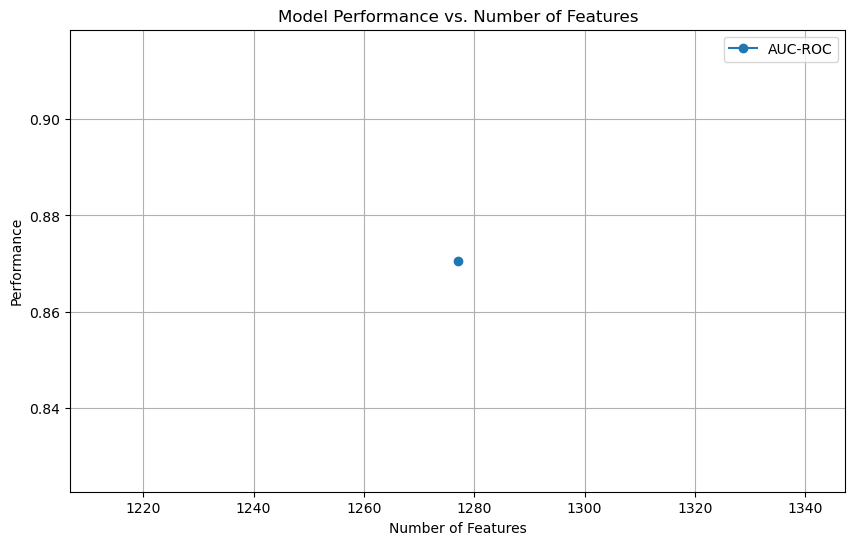

: 

In [7]:
auc_scores = []
n_features_list = [1277]  
rf = LGBMClassifier(random_state=69, n_jobs=-1)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 

for n in n_features_list:
    # Select the top `n` features
    top_n_indices = indices[:n]
    
    # Create datasets with the top `n` features
    X_train_top_n = X_train.iloc[:, top_n_indices]
    X_test_top_n = X_test.iloc[:, top_n_indices]
    
    # Retrain the model using only the top `n` features
    rf.fit(X_train_top_n, y_train)
    
    # Make predictions on the test set
    y_pred = rf.predict(X_test_top_n)
    y_pred_proba = rf.predict_proba(X_test_top_n)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    auc_scores.append(auc_score)
    
    print(f"Features: {n}, AUC: {auc_score}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, auc_scores, label='AUC-ROC', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
plt.title('Model Performance vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()